In [2]:
import sys,os
sys.path.append('/home/marc/flow_ssl/')
import glob
import torch,dill
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from invertible.iresnet import iResBlock
from invertible.iEluNetwork import iConv2d
from invertible.spectral_norm import SN
from invertible.downsample import SqueezeLayer,split,merge,padChannels,keepChannels,NNdownsample,iAvgPool2d
from invertible.clipped_BN import MeanOnlyBN, iBN
import numpy as np
import seaborn as sb
import torch.nn.functional as F
import pandas as pd

In [3]:
paths = glob.glob(os.path.expanduser('~/tb-experiments/iresnet_WTW/**/*.trainer'),recursive=True)
elu_paths = glob.glob(os.path.expanduser('~/tb-experiments/ielu100_iSLReLU_nodev/**/*.trainer'),recursive=True)
elu_paths = glob.glob(os.path.expanduser('~/tb-experiments/elu_flow_full_slrelu2/**/*.trainer'),recursive=True)
elu_paths = glob.glob(os.path.expanduser('~/tb-experiments/nn_srelu_3d_01_nobn/**/*.trainer'),recursive=True)
elu_paths = glob.glob(os.path.expanduser('~/tb-experiments/nn_srelu_3d_01_nobn2_sigmoid2/**/*.trainer'),recursive=True)

paths = elu_paths
print(paths)


['/home/marc/tb-experiments/nn_srelu_3d_01_nobn2_sigmoid2/CIFAR10/iEluNet3d/0.0003/trial0/checkpoints/c10.trainer']


In [4]:
trainer = torch.load(paths[0],pickle_module=dill)
trainer.model.eval();

In [5]:
#trainer.model

In [ ]:
def change_tol(module):
    if isinstance(module,iResBlock):
        module.inverse_tol=1e-10
        print(module.iters_per_reverse)
    if isinstance(module,SN):
        print(module._s)
    if isinstance(module,iConv2d):
        print(module._reverse_iters)
        try: print(module.iters_per_reverse)
        except ZeroDivisionError: pass
trainer.model.apply(change_tol);

In [ ]:
zs = []
with torch.no_grad():
    for mb in trainer.dataloaders['train']:
        z = trainer.model.body(mb[0]).cpu().data.numpy()
        zs.append(z)
        if len(zs) > 100: break


In [ ]:
len(trainer.dataloaders['train'])

In [ ]:
zs[0].shape

In [ ]:
import os
from oil.datasetup.datasets import CIFAR10,CIFAR100
from oil.model_trainers.classifier import Classifier,simpleClassifierTrial
# from resnets import SplitODEResnet,ODEResnet,LongResnet,RNNBottle
# from resnets import SmallResnet,RNNResnet
from invertible.iEluNetwork import iEluNet,iEluNetMultiScaleLarger,iEluNet3d
from oil.tuning.study import Study, train_trial
import torch.nn as nn
from torch.utils.data import DataLoader
from oil.utils.utils import LoaderTo, cosLr, recursively_update,islice
from oil.tuning.study import train_trial
from oil.datasetup.dataloaders import getLabLoader
from oil.datasetup.datasets import CIFAR10
from oil.architectures.img_classifiers import layer13s
from invertible.iresnet import iResnet,iResnetLarge
import collections
trainset = CIFAR10('~/datasets/{}/'.format(CIFAR10))
device = torch.device('cuda')
fullCNN = nn.Sequential(iEluNet3d(num_classes=trainset.num_classes,k=32).to(device))
        
dataloaders = {}
dataloaders['train'], dataloaders['dev'] = getLabLoader(trainset,amnt_dev=0,lab_BS=64)
dataloaders = {k:LoaderTo(v,device) for k,v in dataloaders.items()}
trainer = Classifier(fullCNN,dataloaders)
trainer.model.eval()

In [ ]:
Zs = np.concatenate(zs)

In [ ]:
Zs.shape
z0_cuda = torch.from_numpy(Zs[:1]).cuda()

In [ ]:
z0_cuda

In [ ]:
trainer.model[1].body.inverse(z0_cuda)

In [ ]:
#sb.distplot(Zs[:,0])
for i in range(10):
    sb.distplot(Zs[:,i]+1*i,kde=False,label=i)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()

In [10]:
def get_nlls(dataloader):
    nlls = []
    with torch.no_grad():
        for mb in dataloader:
            nlls.append(trainer.model.nll(mb[0]).cpu().data.numpy())
    return np.concatenate(nlls)

In [7]:
from oil.datasetup.datasets import CIFAR10,CIFAR100,SVHN
from torch.utils.data import DataLoader
from oil.utils.utils import LoaderTo

In [8]:
C100,SVHN_ = [dataset(f'~/datasets/{dataset}/',flow=True) for dataset in (CIFAR100,SVHN)]
C100L,SVHNL =  [LoaderTo(DataLoader(data,batch_size=50,shuffle=False),torch.device('cuda')) for data in (C100,SVHN_)]

Files already downloaded and verified
Using downloaded and verified file: /home/marc/datasets/SVHN/train_32x32.mat


In [43]:
train_nlls = get_nlls(trainer.dataloaders['train'])
dev_nlls = get_nlls(trainer.dataloaders['test'])
C100_nlls = get_nlls(C100L)
SVHN_nlls = get_nlls(SVHNL)

In [ ]:
sb.distplot(train_nlls)
sb.distplot(dev_nlls)
sb.distplot(C100_nlls)
sb.distplot(SVHN_nlls)
plt.legend(["train","dev","CIFAR100","SVHN"])

In [12]:
for mb in trainer.dataloaders['test']:
    break
inp =x=mb[0]
k = 50
with torch.no_grad():
    output = trainer.model.body(inp)
    inp_rec = trainer.model.body.inverse(output)

In [ ]:
# for module in trainer.model.body._modules.values():
#     print(module)

In [ ]:
print(trainer.model.body[11])

In [13]:
((inp_rec - inp).norm()/(inp).norm())

tensor(0.0501, device='cuda:0')

In [ ]:
%debug

In [ ]:
inp_rec.shape

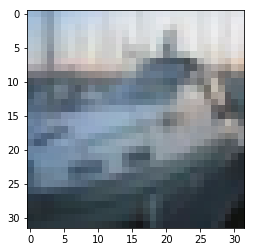

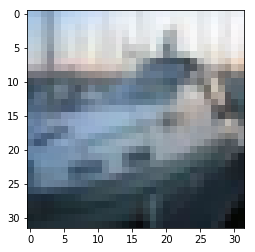

In [14]:
plt.imshow(inp_rec[2].cpu().data.numpy().transpose((1,2,0)))
plt.show()
plt.imshow(inp[2].cpu().data.numpy().transpose((1,2,0)))
plt.show()

In [15]:
((inp_rec - inp).norm()/(inp).norm())

tensor(0.0501, device='cuda:0')

In [ ]:
plt.hist(output.cpu().numpy().reshape(-1))

In [ ]:
with torch.no_grad():
    output = trainer.model.body(inp)

In [ ]:
output[0].shape

In [17]:
trainer.model.eval()
with torch.no_grad():
    sampled_imgs = trainer.model.sample(32).cpu().data

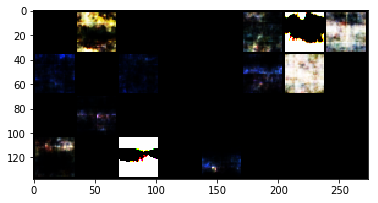

In [23]:
means = np.array([0.4914, 0.4822, 0.4465])
stds = np.array([.247,.243,.261])

grid = vutils.make_grid(torch.from_numpy(sampled_imgs.numpy()), normalize=True,scale_each=True)
plt.imshow(grid.permute(1,2,0))

In [ ]:
grid.shape

In [ ]:
list(z_.shape for z_ in output)

In [ ]:
with torch.no_grad():
    inp_reconstructed = trainer.model.body.inverse(output);

In [ ]:
((inp_reconstructed[3] - inp[3]).norm()/(inp[3]).norm())

In [ ]:
inp_reconstructed.shape

In [25]:
output.shape

torch.Size([50, 192, 4, 4])

In [39]:
starts = output[:25:5]
ends = output[25::5]
t = torch.linspace(0,1,10)[:,None,None,None,None].cuda()
interps = (starts*t+(1-t)*ends).permute(1,0,2,3,4).reshape(-1,*starts.shape[1:])

In [40]:
interps.shape

torch.Size([50, 192, 4, 4])

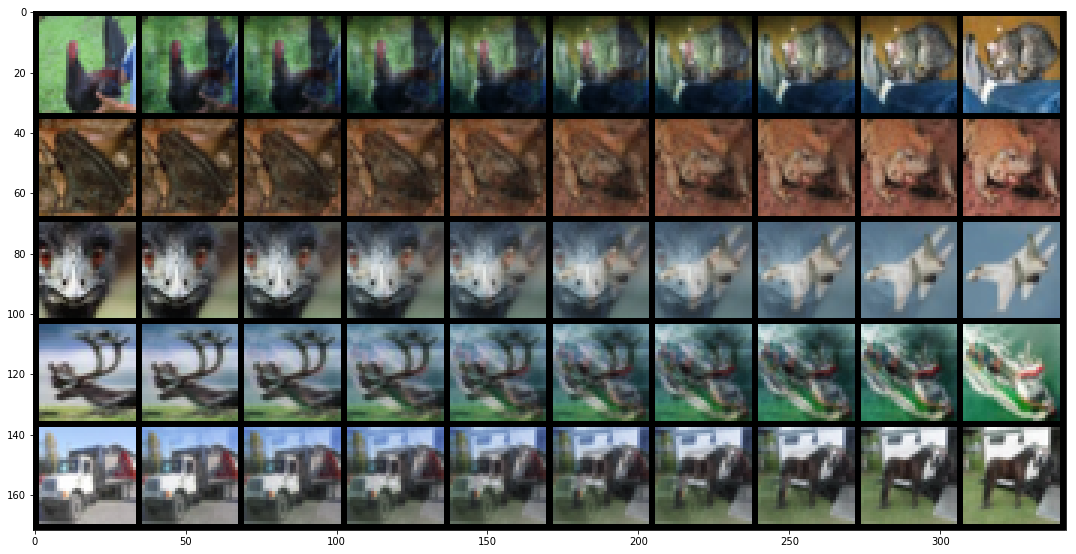

In [42]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
grid = vutils.make_grid(trainer.model.inverse(interps),normalize=True,nrow=10).cpu().data.numpy().transpose(1,2,0)
plt.imshow(grid)
plt.show()
#fig.set_size_inches(5, 4)
fig.savefig('latent_interp.pdf',bbox_layout="tight")

In [ ]:
plt.hist(inp_reconstructed[0].cpu().data.numpy().reshape(-1),alpha=.5)
plt.hist(inp[0].cpu().data.numpy().reshape(-1),alpha=.5)

In [ ]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#print(y.shape)
grid = vutils.make_grid(mb[0],normalize=True).cpu().data.numpy().transpose(1,2,0)
plt.imshow(grid)
plt.show()
grid = vutils.make_grid(inp_reconstructed,normalize=True).cpu().data.numpy().transpose(1,2,0)
plt.imshow(grid)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
for zi in z: print(zi.shape)

In [ ]:
import torch
from downsample import SqueezeLayer
from downsample import NNdownsample,iAvgPool2d

In [ ]:
S = SqueezeLayer(2)

In [ ]:
x = torch.Tensor([0,1,2,3,4,5,6,7]).reshape(1,2,2,2)

In [ ]:
S(x)

In [ ]:
x

In [ ]:
z = S(x-F.interpolate(F.interpolate(x,scale_factor=1/2),scale_factor=2))

In [ ]:
S2 = iAvgPool2d()#NNdownsample()

In [ ]:
x

In [ ]:
S2.inverse(S2(x))

In [ ]:
S2(x)

In [14]:
x = np.linspace(-10,5,100)
beta = .1
alpha = (1-beta)/(1+beta)
relu = lambda x: (x>=0)*x
elu = lambda x: (x>=0)*x +  (x<0)*(np.exp(x)-1)
lelu = lambda x: (x+alpha*(np.sqrt(1+x**2)))/(1+alpha)
leakyrelu = lambda x: (x>=0)*x +  (x<0)*beta*x

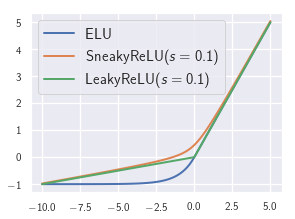

In [15]:
import seaborn as sns
sns.set()
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
#plt.rcParams.update({'font.size': 50})
#rc('xtick.major', pad=12)
#rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)
ms=20
lw=2
fs = 15
#plt.plot(x,relu(x),lw=lw)
plt.plot(x,elu(x),lw=lw)
plt.plot(x,lelu(x),lw=lw)
plt.plot(x,leakyrelu(x),lw=lw)#(x) = $(x+\alpha(\sqrt{1+x^2}-1))/(1+\alpha)$",r"LeakyReLU($\beta = 0.1$)
plt.legend(["ELU",r"SneakyReLU($s = 0.1$)",r"LeakyReLU($s = 0.1$)"],fontsize=fs)
fig = plt.gcf()
fig.set_size_inches(4.5, 3.3)

fig.savefig('sneaky.pdf',bbox_layout="tight")

In [ ]:
def slrelu_inverse(y,a):
    b = (1+a)*y + a
    x = (np.sqrt(a**2 + (a*b)**2-a**4) - b)/(a**2-1)
    return x

In [ ]:
from invertible.iEluNetwork import TestFFTConv

In [ ]:
T = TestFFTConv()

In [ ]:
T.test_ifftconv()